## Poisson Process Sessions Baseline

The goal of the notebook is to learn the rate of the Poisson Process (PP) in application to modeling user session length. In a Poisson Process [1], the inter-arrival times (session lengths) are assumed to be independent and identically distributed (iid) exponential random variables, while the number (or count) of events is distributed as a Poisson random variable:

$$x_i \sim \mathrm{Exp}(\lambda)= \lambda \exp\{-\lambda x\}$$

$$\mathrm{Poiss}(k;\lambda, t) = \frac{(\lambda t)^{k}}{k!}\exp\{-\lambda t\}$$

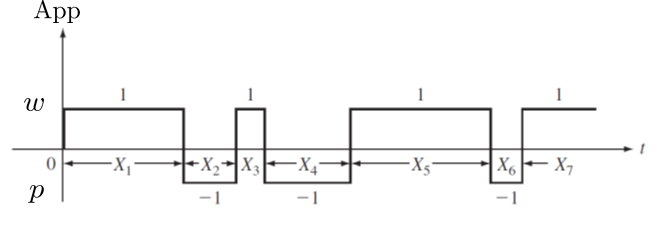

In [4]:
from IPython.display import Image
Image("figures/random_process.png")

The figure above shows the variable length session windows: $\{x_1,...,x_k\}$ of alternating switching process between (w)ork and (p)lay events. Given the training data, our goal is to learn the arrival rate $\lambda$ that captures an average frequency of sessions. We can use Monte Carlo sampling methods and in particular PyMC3 library [2] to do that. Note: we can also look at non-homogenuous Poisson process where the arrival rate lambda is a function of time: $\lambda(t)$

In [88]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.models import load_model

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [127]:
#load data
print("loading App data...")
train_df = pd.read_csv('./data/AppResult.csv', sep=',')
train_df.head()

loading App data...


,DateTime,Process,Label
0,2019-08-01 11:39:08.462313,System Idle Process,work
1,2019-08-01 11:39:08.479314,System,work
2,2019-08-01 11:39:08.517314,Secure System,work
3,2019-08-01 11:39:08.551314,Registry,work
4,2019-08-01 11:39:08.580315,smss.exe,work


Let's convert start and end times to pandas datetime:

In [27]:
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df.columns = ['Start', 'Process', 'Label']
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 3 columns):
Start      1604 non-null datetime64[ns]
Process    1604 non-null object
Label      1604 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 37.7+ KB


In [28]:
train_df.head()

,Start,Process,Label
0,2019-08-01 11:39:08.462313,System Idle Process,work
1,2019-08-01 11:39:08.479314,System,work
2,2019-08-01 11:39:08.517314,Secure System,work
3,2019-08-01 11:39:08.551314,Registry,work
4,2019-08-01 11:39:08.580315,smss.exe,work


Let's compute time intervals between activity start times and a maximum likelihood estimate for lambda: $\lambda = \frac{1}{E[X_i]} = \frac{1}{ \frac{1}{n}\sum_{i=1}^{n}x_i}$

In [29]:
train_df['delta'] = train_df['Start'].shift(-1) - train_df['Start']
train_df['delta_microsec'] = list(map(lambda x: x.microseconds, train_df['delta']))
train_df['lambda_mle_mhz'] = 1.0 / (train_df['delta_microsec'].cumsum() / (train_df['delta_microsec'].index.values+1))
train_df['activity_cnt'] = np.arange(1,train_df.shape[0]+1)

In [30]:
train_df.head()

,Start,Process,Label,delta,delta_microsec,lambda_mle_mhz,activity_cnt
0,2019-08-01 11:39:08.462313,System Idle Process,work,00:00:00.017001,17001.0,0.000059,1
1,2019-08-01 11:39:08.479314,System,work,00:00:00.038000,38000.0,0.000036,2
2,2019-08-01 11:39:08.517314,Secure System,work,00:00:00.034000,34000.0,0.000034,3
3,2019-08-01 11:39:08.551314,Registry,work,00:00:00.029001,29001.0,0.000034,4
4,2019-08-01 11:39:08.580315,smss.exe,work,00:00:00.019001,19001.0,0.000036,5


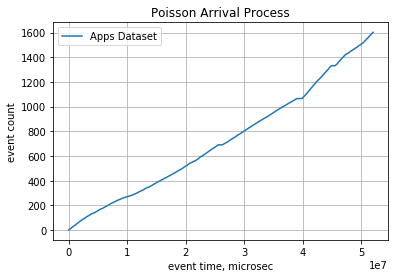

In [36]:
plt.plot(train_df['delta_microsec'].cumsum(), train_df['activity_cnt'], label='Apps Dataset')
plt.xlabel("event time, microsec"); plt.ylabel("event count"); plt.grid(True); plt.title("Poisson Arrival Process"); plt.legend()

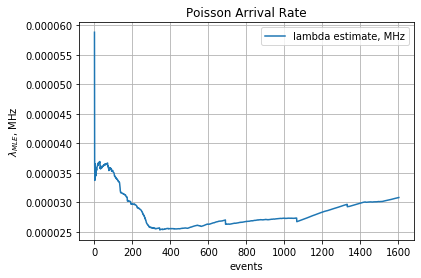

In [37]:
plt.plot(train_df['lambda_mle_mhz'], label='lambda estimate, MHz')
plt.xlabel("events"); plt.ylabel("$\lambda_{MLE}$, MHz"); plt.grid(True); plt.title("Poisson Arrival Rate"); plt.legend()

Let's define session window length equal to ($mode - 0.5\times \sigma$) where sigma is one standard deviation:

In [115]:
session_len = (train_df['delta_microsec'].dropna().mode() - 0.5*train_df['delta_microsec'].dropna().std()).values
print("fix session length at [microsec]: ", session_len)

fix session length at [microsec]:  [9102.23316605]


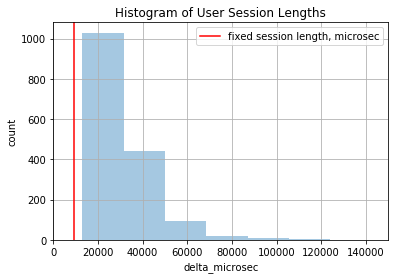

In [116]:
sns.distplot(train_df['delta_microsec'].dropna(), kde=False); plt.xlim([0, 150000]);
plt.title("Histogram of User Session Lengths"); plt.ylabel("count"); plt.grid(True);
plt.axvline(x=session_len, c='r', label='fixed session length, microsec')
plt.legend()

In [117]:
session_df = pd.DataFrame(data={'time_microsec':[0.0], 'session':['work'], 'counter':[0]})

row_cnt = 1
current_time = 0
num_sessions = train_df.shape[0]
for i in range(1, num_sessions):
    remaining_time = train_df.loc[i,'delta_microsec']
    current_session = train_df.loc[i,'Label']
    while (remaining_time >= 0):
        current_time += session_len
        remaining_time = remaining_time - session_len
        session_df.loc[row_cnt, 'time_microsec'] = current_time
        session_df.loc[row_cnt, 'session'] = current_session
        if (current_session == 'work'):
            session_df.loc[row_cnt, 'counter'] = session_df.loc[row_cnt-1, 'counter'] + 1
        else:
            session_df.loc[row_cnt, 'counter'] = session_df.loc[row_cnt-1, 'counter'] - 1
        row_cnt+=1
    #end while
#end for

In [118]:
session_df.head()

,time_microsec,session,counter
0,0.000000,work,0.0
1,9102.233166,work,1.0
2,18204.466332,work,2.0
3,27306.699498,work,3.0
4,36408.932664,work,4.0


In [119]:
session_df.shape

(6495, 3)

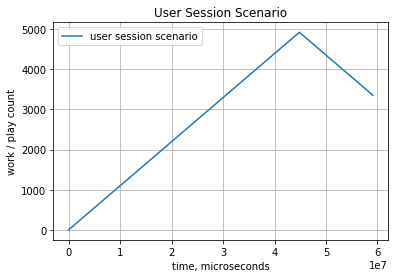

In [120]:
plt.plot(session_df['time_microsec'].values, session_df['counter'].values, label='user session scenario')
plt.title("User Session Scenario"); plt.xlabel("time, microseconds"); plt.ylabel("work / play count");
plt.grid(True); plt.legend()

In [85]:
train_df['delta_microsec'].cumsum()

0          17001.0
1          55001.0
2          89001.0
3         118002.0
4         137003.0
5         170002.0
6         196002.0
7         227002.0
8         261001.0
9         284001.0
10        308001.0
11        339002.0
12        366002.0
13        390001.0
14        417003.0
15        443001.0
16        470002.0
17        494002.0
18        521002.0
19        546002.0
20        579000.0
21        603001.0
22        628000.0
23        655001.0
24        682002.0
25        706002.0
26        736002.0
27        761001.0
28        786003.0
29        813999.0
           ...    
1574    51504071.0
1575    51519078.0
1576    51541086.0
1577    51561089.0
1578    51579076.0
1579    51594067.0
1580    51612069.0
1581    51633071.0
1582    51650067.0
1583    51668070.0
1584    51688071.0
1585    51708067.0
1586    51724076.0
1587    51747068.0
1588    51764077.0
1589    51782071.0
1590    51804077.0
1591    51825088.0
1592    51841065.0
1593    51865085.0
1594    51885081.0
1595    5190

In [84]:
session_df.head()

,time,session
0,0.0,work


### References

[1] J. Kingman, "Poisson Processes", Oxford Studies in Probability, Clarendon Press, 1993  
[2] A. Patil et al. PyMC: Bayesian Stochastic Modelling in Python, Journal of Statistical Software, 2010